Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original Image Saliency Maps:


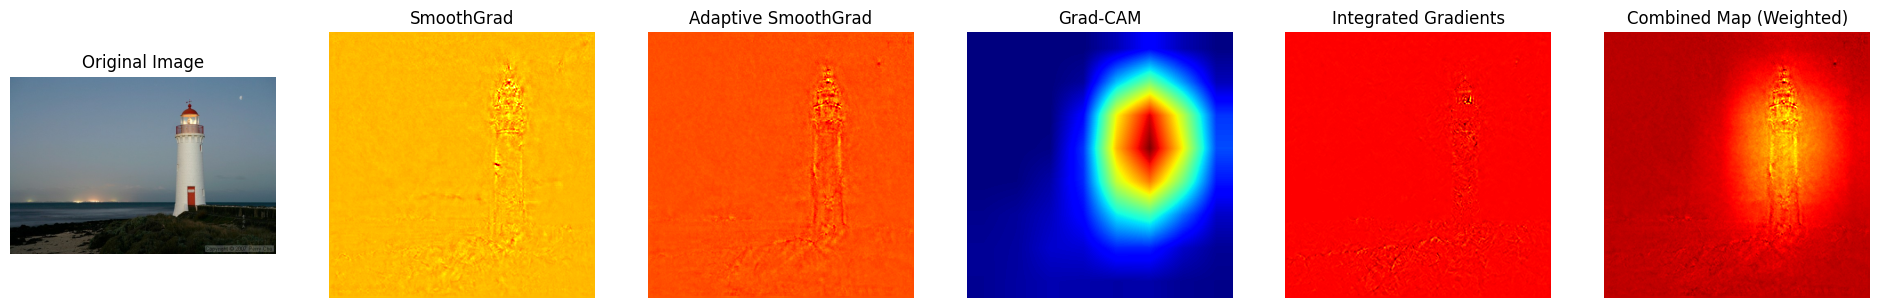

Adversarial Image Saliency Maps:


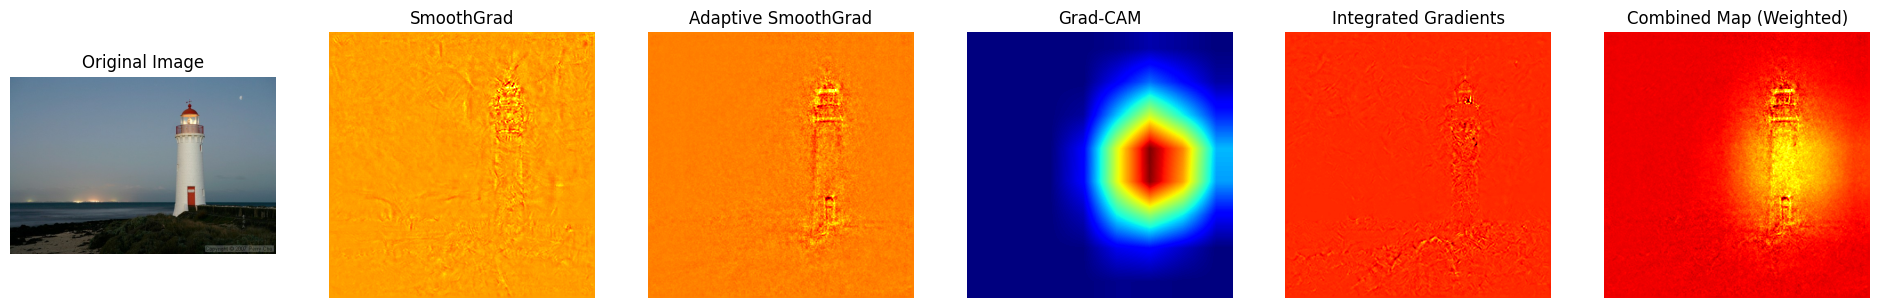

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

model = models.inception_v3(weights="IMAGENET1K_V1")
#model = models.resnet50(weights="IMAGENET1K_V1")
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
transform = transforms.Compose([transforms.Resize((299, 299)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
#transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])


def smooth_grad(image, model, target_class, noise_level=0.1, n_samples=50):
    gradients = torch.zeros_like(image).to(device)
    for _ in range(n_samples):
        noise = torch.randn_like(image) * noise_level
        noisy_image = image + noise
        noisy_image = Variable(noisy_image, requires_grad=True)

        output = model(noisy_image)
        model.zero_grad()

        loss = output[0, target_class]
        loss.backward()

        gradients += noisy_image.grad

    gradients /= n_samples
    gradients = gradients.squeeze()
    return (gradients - gradients.min()) / (gradients.max() - gradients.min())

def adaptive_sg(image, model, target_class, base_noise=0.1, scale=2.0, n_samples=50):
    output = model(image)
    probabilities = F.softmax(output, dim=1)
    entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-5))
    noise_level = base_noise * (1 + scale * entropy.item())

    gradients = torch.zeros_like(image).to(device)
    for _ in range(n_samples):
        noise = torch.randn_like(image) * noise_level
        noisy_image = image + noise
        noisy_image = Variable(noisy_image, requires_grad=True)

        output = model(noisy_image)
        model.zero_grad()

        loss = output[0, target_class]
        loss.backward()

        gradients += noisy_image.grad

    gradients /= n_samples
    gradients = gradients.squeeze()
    return (gradients - gradients.min()) / (gradients.max() - gradients.min())

def grad_cam(image, model, target_class):
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    target_layer = model.Mixed_7c
    #target_layer = model.layer4[-1]
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)

    output = model(image)
    model.zero_grad()
    loss = output[0, target_class]
    loss.backward()

    grad = gradients[0].cpu().data.numpy()
    act = activations[0].cpu().data.numpy()

    weights = np.mean(grad, axis=(2, 3))[0, :]
    cam = np.zeros(act.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * act[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (299, 299))
    return (cam - cam.min()) / (cam.max() - cam.min())

def int_grad(image, model, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(image).to(device)

    scaled_images = [baseline + (float(i) / steps) * (image - baseline) for i in range(steps + 1)]
    gradients = []

    for scaled_image in scaled_images:
        scaled_image = Variable(scaled_image, requires_grad=True)
        output = model(scaled_image)
        model.zero_grad()

        loss = output[0, target_class]
        loss.backward()

        gradients.append(scaled_image.grad)

    avg_grad = torch.stack(gradients).mean(dim=0)
    int_grad = (image - baseline) * avg_grad
    int_grad = int_grad.sum(dim=1).squeeze()
    return (int_grad - int_grad.min()) / (int_grad.max() - int_grad.min())

def weighted_maps(adaptive_sg_map, grad_cam_map, int_grad_map):
    comb_map = 0.6 * adaptive_sg_map + 0.2 * grad_cam_map + 0.2 * int_grad_map
    return (comb_map - comb_map.min()) / (comb_map.max() - comb_map.min())

def normalize_maps(*maps):
    all_maps = np.concatenate([m.flatten() for m in maps if m is not None])
    global_min, global_max = np.min(all_maps), np.max(all_maps)
    if global_min == global_max:
        return [np.zeros_like(m) for m in maps]
    return [(m - global_min) / (global_max - global_min) for m in maps]

def visualize(org_image, smooth_grad_map, adaptive_sg_map, grad_cam_map, int_grad_map, comb_map):
    fig, axs = plt.subplots(1, 6, figsize=(24, 5))
    axs[0].imshow(org_image)
    axs[0].set_title("Original Image")

    axs[1].imshow(smooth_grad_map, cmap='hot')
    axs[1].set_title("SmoothGrad")

    axs[2].imshow(adaptive_sg_map, cmap='hot')
    axs[2].set_title("Adaptive SmoothGrad")

    axs[3].imshow(grad_cam_map, cmap='jet')
    axs[3].set_title("Grad-CAM")

    axs[4].imshow(int_grad_map, cmap='hot')
    axs[4].set_title("Integrated Gradients")

    axs[5].imshow(comb_map, cmap='hot')
    axs[5].set_title("Combined Map (Weighted)")

    for ax in axs:
        ax.axis('off')
    plt.show()

def it_fgsm(image, epsilon, alpha, iterations, model, target_class):
    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad = True

    for _ in range(iterations):
        output = model(perturbed_image)
        loss = F.nll_loss(output, torch.tensor([target_class]).to(device))
        #loss = F.cross_entropy(output, torch.tensor([target_class]).to(device))
        model.zero_grad()
        loss.backward()
        perturbed_image = perturbed_image + alpha * perturbed_image.grad.sign()
        perturbation = torch.clamp(perturbed_image - image, min=-epsilon, max=epsilon)
        perturbed_image = (image + perturbation).detach()
        perturbed_image.requires_grad = True

    return perturbed_image

def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0)
    return Variable(img, requires_grad=True).to(device)

image_path = '/content/drive/My Drive/Colab Notebooks/n02814860_65778.JPEG'
#n01667114_2539.JPEG
#n01440764_1775.JPEG
#n01531178_22240.JPEG
#n09193705_21943.JPEG

#n02814860_65778.JPEG

#n03000247_18895.JPEG
#n12620546_3891.JPEG
#n12267677_3433.JPEG
#n07760859_6577.JPEG

#n02106550_10005.JPEG

#n01484850_7557.JPEG
#n02108422_6203.JPEG
org_image = Image.open(image_path).convert('RGB')
image = load_image(image_path)

output = model(image)
_, target_class = torch.max(output, 1)

smooth_grad_map = smooth_grad(image, model, target_class.item())
adaptive_sg_map = adaptive_sg(image, model, target_class.item())
grad_cam_map = grad_cam(image, model, target_class.item())
int_grad_map = int_grad(image, model, target_class.item())
comb_map = weighted_maps(adaptive_sg_map.detach().cpu().numpy()[0, :, :], grad_cam_map, int_grad_map.detach().cpu().numpy())

(smooth_grad_map, adaptive_sg_map, grad_cam_map, int_grad_map, comb_map) = normalize_maps( smooth_grad_map.detach().cpu().numpy()[0, :, :], adaptive_sg_map.detach().cpu().numpy()[0, :, :], grad_cam_map, int_grad_map.detach().cpu().numpy(), comb_map)

print("Original Image Saliency Maps:")
visualize(org_image, smooth_grad_map, adaptive_sg_map, grad_cam_map, int_grad_map, comb_map)

epsilon = 0.1
alpha = 0.01
iterations = 20
fgsm_image = it_fgsm(image, epsilon, alpha, iterations, model, target_class.item())

fgsm_sg_map = smooth_grad(fgsm_image, model, target_class.item())
fgsm_adaptive_sg_map = adaptive_sg(fgsm_image, model, target_class.item())
fgsm_grad_cam_map = grad_cam(fgsm_image, model, target_class.item())
fgsm_int_grad_map = int_grad(fgsm_image, model, target_class.item())
fgsm_comb_map = weighted_maps(fgsm_adaptive_sg_map.detach().cpu().numpy()[0, :, :], fgsm_grad_cam_map, fgsm_int_grad_map.detach().cpu().numpy())

(fgsm_sg_map, fgsm_adaptive_sg_map, fgsm_grad_cam_map, fgsm_int_grad_map, fgsm_comb_map) = normalize_maps(fgsm_sg_map.detach().cpu().numpy()[0, :, :], fgsm_adaptive_sg_map.detach().cpu().numpy()[0, :, :], fgsm_grad_cam_map, fgsm_int_grad_map.detach().cpu().numpy(), fgsm_comb_map)

print("Adversarial Image Saliency Maps:")
visualize(org_image, fgsm_sg_map, fgsm_adaptive_sg_map, fgsm_grad_cam_map, fgsm_int_grad_map, fgsm_comb_map)
